In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
import sklearn

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns

#to print all output from the cell, not just the last line
#from IPython.core.interactiveshell import InteractiveShell


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import SMOTE

#InteractiveShell.ast_node_interactivity = "all"

#toggle printing visualizations
visualizations = True

In [67]:
df = pd.read_csv('data/online_shoppers_intention.csv')

### Business Problem

This classification project examines a dataset of online shopping sessions to predict whether or not the session ended in a purchase. The imagined audience is a web development firm looking to improve the ecommerce functionalities they offer their clients. They are hoping to develop new ecommerce tools and functionalities for their platform. Development of this classification model is the first exploratory step to understand the needs of their clients. This model might pave the way for development and A/B testing of new ecommerce features.

This firm would like to demonstrate their return on their clients' investment by demonstrating how they might help their clients convert traffic into sales. Those clients might be small(ish) business owners, who are hoping to optimize their advertising strategies, learn what types of customers to target, and drive overall sales.

### Data Understanding

For this project, I used a dataset titled "Online Shoppers Purchasing Intention" from the UCI Machine Learning Repository. The data was used in a 2018 article on machine learning models' potential for predicting user behavior in ecommerce sites, and was donated to the repository in 2018 

After spending some time with the data, I informally organized the 18 features into several categories:

<b> Type of pages visited and session duration </b> <br>
These features include the number of Administrative, Informational, and Product-Related pages visited in the session, and the total duration spent in each of those categories in seconds.

<b> Qualities of pages visited </b> <br>
This section includes Google analytics data for the pages visited in this session, aggregated by mean. Includes Bounce Rates (frequency of sessions that enter and exit on a given page), Exit Rates (frequency of sessions that end on this page), and Page Values (rate at which the given page leads to a purchase) for each page.

<b> Season session occurred </b> <br>
These two features indicate which month the session occurred, and the session's proximity to one of two designated 'Special Day's, or days expected to yield a high number of gift purchases (Valentine's Day and Mother's Day). 

<b> User information </b> <br>
Finally, there was a handful of data about the user collected for each session: the operating system and browser type used to access the site, and the region where the user is located. Additionally, we know how the user came to the site (Traffic Type) and if they had previously visited the site (Visitor Type). Whether the session occurred on a weekend is captured in Weekend.

In [68]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


I added the total page views and the total time spent on the site as additional features. I expected that these features would correlate strongly with Producted Related counts and duration, but thought that it was useful to capture how the user interacted with the overall site during their session. 

In [69]:
#create new features by summing existing features
df['Total_Pages'] = df.apply(lambda row: row.Administrative + row.Informational + row.ProductRelated, axis=1)
df['Total_Duration'] = df.apply(lambda row: row.Administrative_Duration + row.Informational_Duration + row.ProductRelated_Duration, axis=1)

#move the new columns to a place in the dataset where I prefer them
cols = df.columns.tolist()
new_cols = cols[:6] + cols[-2:] + cols[6:-2]

df = df[new_cols]
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Total_Pages,Total_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [70]:
#create lists of categorical/continuous features for visualizations and piplining

categorical_feats = df.columns.tolist()[12:-1]
numerical_feats = df.columns.tolist()[:12]

# print(categorical_feats)
# print(numerical_feats)

#some housekeeping to keep the months in order in visualizations

months = ["Feb", "Mar", "May", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

#### Visualizations

In [71]:
for each in categorical_feats:
    fig = px.histogram(df, x=each, color='Revenue')
    fig.show()

In [72]:
#to simplify visualizations
df["Invert_Revenue"] = (df['Revenue']==0).astype(int)

for each in categorical_feats:
    categories = df[each].unique().tolist()
    categories.sort    
    sales = df.groupby(each)['Revenue'].sum().tolist()
    passes = df.groupby(each)['Invert_Revenue'].sum().tolist()

    fig = go.Figure()
    fig.add_bar(x=categories, y=passes, name='No Sale').add_bar(x=categories, y=sales, name='Sale').update_layout(title_text = each, barmode='stack')
    fig.show()

#### Other

I considered the possibility that the site the data represented was new, or had been newly linked to Google Analytics for the purposes of the project. I wanted to see if the Google Analytics features would change over time as more users interacted with the site. After printing out the following visualizations, it seems that the distribution of data over time parallels that of other features plotted against Month. 

In [73]:
# fig = make_subplots(rows=3, cols=1)

# fig.append_trace(go.Scatter(
#     x = df["Month"], y=df["BounceRates"],
#     name='Bounce Rates',
#     mode='markers',
#     marker_color='blue'
# ), row=1, col=1)

# fig.append_trace(go.Scatter(
#     x = df["Month"], y=df["ExitRates"],
#     name='Exit Rates',
#     mode='markers',

#     marker_color='red'
# ), row=2, col=1)

# fig.add_trace(go.Scatter(
#     x = df["Month"], y=df["PageValues"],
#     name='Page Values',
#     mode='markers',
#     marker_color='green'
# ), row=3, col=1)

In [74]:
visualizations = False
if visualizations:    
    fig = make_subplots(rows=3, cols=1)

    fig.append_trace(go.Scatter(
        x = df["Month"], y=df["BounceRates"],
        name='Bounce Rates',
        mode='markers',
        marker_color = '#22577a'
    ), row=1, col=1)

    fig.append_trace(go.Scatter(
        x = df["Month"], y=df["ExitRates"],
        name='Exit Rates',
        mode='markers',
        marker_color='#38a3a5'
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x = df["Month"], y=df["PageValues"],
        name='Page Values',
        mode='markers',
        marker_color='#57cc99'
    ), row=3, col=1)

    fig.update_layout(hovermode=False)
    #this line of code took me 45 minutes rip
    fig.update_xaxes(categoryorder = 'array', categoryarray=np.array(months))
    fig.show()

After reading the scant literature on the conceptualization of the 'Special Day' feature, I wanted to explore it further. Is there a 'Special Day' for each month? Which days are 'Special'? Do they correlate with sales peaks?

My investigation was short, as it turns out there were only two 'Special Days', and they were those named in the study: Valentine's Day and Mother's Day

In [75]:
df.groupby('Month')['SpecialDay'].mean()

Month
Aug     0.000000
Dec     0.000000
Feb     0.233696
Jul     0.000000
June    0.000000
Mar     0.000000
May     0.212366
Nov     0.000000
Oct     0.000000
Sep     0.000000
Name: SpecialDay, dtype: float64

As attentive readers may have noticed, this dataset is missing several months' worth of data! We have no data for January, April, or June. In addition to having incomplete monthly data, this also renders the overall counts from month-to-month suspect, ad we're not sure if certain months are lower count due to lower traffic, or due to errors in data collection. 

### Data Preparation

Several of my categorical variables has categories with counts so low that when the data was split into training and test data, some categories wouldn't appear in the test data. For consistency across the training and test data, I grouped low-count categories into a single 'other' (coded as '99', since the categories were all integers). 

In [77]:
#columns with low-count categories
sm_outliers = ['OperatingSystems', 'Browser', 'TrafficType']

#this loop codes any low-count category as a single replacement value. I chose 99
for each in sm_outliers:
    #code snippet below from stackoverflow
    series = pd.value_counts(df[each])
    mask = (series/series.sum() * 100).lt(1)
    # To replace df['column'] use np.where I.e 
    df[each] = np.where(df[each].isin(series[mask].index),99,df[each])
    
    #print(df[each].value_counts())

In [103]:
#correctly type casting some features
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

#removing Invert Revenue because it helps the models
#if visualizations:
df.drop('Invert_Revenue', axis=1, inplace=True )

Here I did the test-train split, separating out 20% of my data to test my models for overfitting.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Revenue', axis=1), df['Revenue'], test_size=0.2, random_state=270)

Although I initially wanted to use a Pipeline for my modeling, I found that I needed to use the SMOTE sampling strategy to balance my data. The SMOTE tool doesn't work into a sklearn Pipeline, and the imblearn Pipeline doesn't work with sklearn models. For that reason, I created dummy variables and scaled the data by hand, and saved those values in separate variables from those I entered into the Pipeline.

In [105]:
#create dummies for categorical features
processed_train = pd.get_dummies(X_train, columns=categorical_feats)
processed_test = pd.get_dummies(X_test, columns=categorical_feats)

#save the columns for later
processed_columns = processed_train.columns.to_list()

#fit the scaler on the training data
x_scale = StandardScaler().fit(processed_train)

#create scaled X-values
processed_train = x_scale.transform(processed_train)
processed_test = x_scale.fit_transform(processed_test)

#I'm still not sure if I should be scaling my targets or not?
#Most of the models didn't like having scaled models
#if I need it in a pinch, it's here.

#processed_y_train = y_train.to_numpy().reshape(-1,1)
#y_scale = StandardScaler().fit(processed_y_train)
#processed_y_train = y_scale.transform(processed_y_train)
#processed_y_test = y_test.to_numpy().reshape(-1,1)
#processed_y_test = y_scale.transform(processed_y_test)

I did have some occasion to use the sklearn Pipeline, so I constructed one below. The Pipeline accepts separate categorical and numerical data for preprocessing, then joins the two in the ColumnTransformer section of the pipe, which will be invoked alongside the given model.

I didn't end up using this Pipeline as much as I anticipated given the above complication with SMOTE.


In [106]:
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

transformer = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_feats),
    ('cat', cat_pipe, categorical_feats)
])

Here I used SMOTE to create synthetic data points with a positive target (sales) to balance out the negative values (sessions without a sale). Because the class imbalance in my model was pretty dramatic, SMOTE proved to be a really crucial tool. The difference between balanced and unbalanced data will be apparent in the modeling section.  

In [107]:
#use SMOTE to create synthetic columns so that there are an equal number of positive/negative values
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(processed_train, y_train)

### Modeling

#### Logistic Regression

I started with a basic logistic regression model using the pipeline that I had constructed. Since it's going through the pipeline, the data will be one-hot-encoded and scaled. Looks like our accuracy score is pretty good for a first model!


In [108]:
lr_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', LogisticRegression(random_state=270, solver='lbfgs', max_iter=250))
])

lr_pipe.fit(X_train, y_train)

print(lr_pipe.score(X_test, y_test))

y_hat_test = lr_pipe.predict(X_test)
y_hat_train = lr_pipe.predict(X_train)

# residuals = np.abs(y_train - y_hat_train)
# print('Train residuals:')
# print(pd.Series(residuals).value_counts())
# print(pd.Series(residuals).value_counts(normalize=True))

# residuals = np.abs(y_test - y_hat_test)
# print('Test residuals:')
# print(pd.Series(residuals).value_counts())
# print(pd.Series(residuals).value_counts(normalize=True))



0.8856447688564477


Unfortunately, it seems the model is pretty good at predicting when sessions won't end in a sale, but not great at predicting the sales. Although there's a decent precision score, the recall value is very low, creating a low f1- score. Looks like the model needs some tuning.

In [109]:
#helps the table designate which label is which
target_names = ['No Sale', 'Sale']

#print out the metrics associated with the model
print(classification_report(y_train, y_hat_train, target_names=target_names))

              precision    recall  f1-score   support

     No Sale       0.90      0.98      0.94      8337
        Sale       0.75      0.40      0.52      1527

    accuracy                           0.89      9864
   macro avg       0.82      0.69      0.73      9864
weighted avg       0.87      0.89      0.87      9864



Just to mark the starting point, I created confusion matrices for this initial model. As expected, there are more false positives than is acceptable.

[Text(0.5, 15.0, 'True'), Text(33.0, 0.5, 'Predicted')]

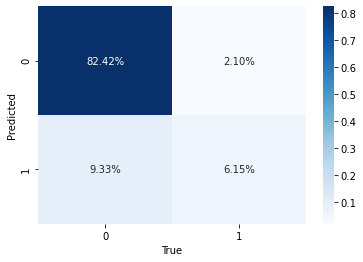

In [110]:
cf_train = confusion_matrix(y_train, y_hat_train)
ax = sns.heatmap(cf_train/np.sum(cf_train), annot=True, fmt='.2%', cmap = 'Blues')
ax.set(xlabel='True', ylabel='Predicted')

[Text(0.5, 15.0, 'True'), Text(33.0, 0.5, 'Predicted')]

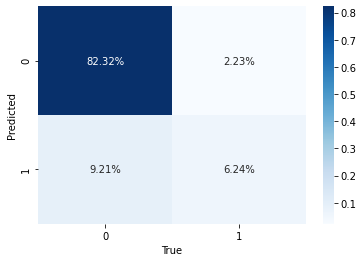

In [111]:
cf_test = confusion_matrix(y_test, y_hat_test)
ax = sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt='.2%', cmap = 'Blues')
ax.set(xlabel='True', ylabel='Predicted')

After seeing the results of the initial pass, I want to correct the dramatic class imbalance of the dataset. I re-fit the model with and instance of the training data that had been balanced with values generated by SMOTE. 

In [122]:
manual_lr = LogisticRegression(random_state=270, solver='lbfgs', max_iter=250)
manual_lr.fit(X_train_resampled, y_train_resampled)
y_hat_train = manual_lr.predict(processed_train)
y_hat_test = manual_lr.predict(processed_test)

With the balanced data, we see a significant drop in the precision of the model, but a serious improvement in the recall. This makes sense: the model is making more positive guesses, resulting in a higher rate of false positives, and thus, a lower prevision. Although the overall accuracy of the model is lower, the f1-score has improved quite a bit. 

In [123]:
#print out the metrics associated with the model
print(classification_report(y_train, y_hat_train, target_names=target_names))

              precision    recall  f1-score   support

     No Sale       0.95      0.87      0.91      8337
        Sale       0.53      0.77      0.63      1527

    accuracy                           0.86      9864
   macro avg       0.74      0.82      0.77      9864
weighted avg       0.89      0.86      0.87      9864



The results are consistent across the training and test data, indicating that the model isn't overfit.

In [124]:
#print out the metrics associated with the model
print(classification_report(y_test, y_hat_test, target_names=target_names))

              precision    recall  f1-score   support

     No Sale       0.96      0.87      0.91      2085
        Sale       0.52      0.78      0.63       381

    accuracy                           0.86      2466
   macro avg       0.74      0.82      0.77      2466
weighted avg       0.89      0.86      0.87      2466



The changes in the confusion matrix demonstrate how the balanced training data redistributed the predictions in the test data.

[Text(0.5, 15.0, 'True'), Text(33.0, 0.5, 'Predicted')]

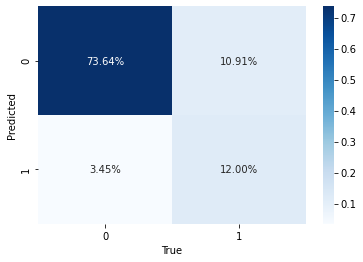

In [121]:
cf_test = confusion_matrix(y_test, y_hat_test)
ax = sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt='.2%', cmap = 'Blues')
ax.set(xlabel='True', ylabel='Predicted')

The ROC curve is pretty strong, which emphasizes that our recall is much improved after having balanced the training data. 

In [114]:
y_score = manual_lr.decision_function(processed_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.9121710505611259


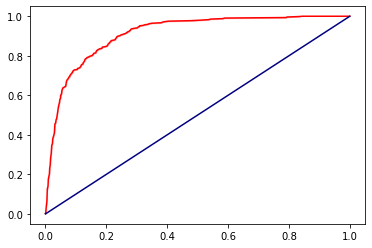

In [115]:
ax = sns.lineplot(x=fpr, y=tpr, color = 'red')
ax = sns.lineplot(x=[0,1], y=[0,1], color='navy')

Although correcting for the class imbalance improved the data quite a bit, the f-1 score is still not as high as it could be. This is as far as logistic regression can take this data for now; however, the model could be improved by using a different model (like a decision tree or random forest) to generate a list of optimal features we could use to better train the logistic model.

#### Decision Tree

I chose the decision tree for my second model to see what a more rigorous model would make of the data. Given that the logistic model was somewhat underfit, I was interested to see how the decision tree would perform.

[Text(153.4622289806334, 214.24235294117648, 'PageValues <= -0.266\nentropy = 0.622\nsamples = 9864\nvalue = [8337, 1527]\nclass = 0'),
 Text(75.19876814272999, 207.8470588235294, 'Month_Nov <= 0.606\nentropy = 0.247\nsamples = 7745\nvalue = [7428, 317]\nclass = 0'),
 Text(34.03677034282761, 201.45176470588234, 'Month_May <= 0.508\nentropy = 0.138\nsamples = 5952\nvalue = [5837, 115]\nclass = 0'),
 Text(33.42154121683703, 195.0564705882353, 'Month_Mar <= 0.957\nentropy = 0.194\nsamples = 3855\nvalue = [3740, 115]\nclass = 0'),
 Text(25.587884030090734, 188.66117647058823, 'Administrative_Duration <= -0.451\nentropy = 0.262\nsamples = 2571\nvalue = [2457, 114]\nclass = 0'),
 Text(11.766257034569888, 182.26588235294116, 'Informational_Duration <= -0.2\nentropy = 0.09\nsamples = 1224\nvalue = [1210, 14]\nclass = 0'),
 Text(7.844171356379925, 175.87058823529412, 'Browser_5 <= 2.366\nentropy = 0.054\nsamples = 1142\nvalue = [1135, 7]\nclass = 0'),
 Text(4.614218444929367, 169.47529411764705

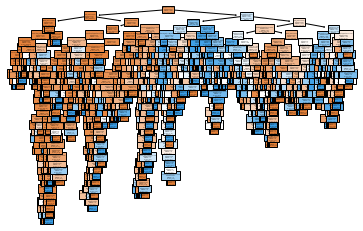

In [120]:
dtc = tree.DecisionTreeClassifier(criterion='entropy')

dtc.fit(processed_train, y_train.to_numpy().reshape(-1,1))

tree.plot_tree(dtc,
             feature_names = processed_columns,
             class_names = np.unique(y_train).astype('str'),
             filled=True)

In [125]:
y_hat_train = dtc.predict(processed_train)
y_hat_test = dtc.predict(processed_test)

print(classification_report(y_train, y_hat_train, target_names=target_names))
print(classification_report(y_test, y_hat_test, target_names=target_names))

              precision    recall  f1-score   support

     No Sale       1.00      1.00      1.00      8337
        Sale       1.00      1.00      1.00      1527

    accuracy                           1.00      9864
   macro avg       1.00      1.00      1.00      9864
weighted avg       1.00      1.00      1.00      9864

              precision    recall  f1-score   support

     No Sale       0.92      0.92      0.92      2085
        Sale       0.56      0.57      0.56       381

    accuracy                           0.86      2466
   macro avg       0.74      0.74      0.74      2466
weighted avg       0.87      0.86      0.86      2466



[Text(168.2048076923077, 199.32, 'PageValues <= -0.317\nentropy = 1.0\nsamples = 16674\nvalue = [8337, 8337]\nclass = 0'),
 Text(83.7, 163.07999999999998, 'Month_Nov <= -0.516\nentropy = 0.484\nsamples = 8252\nvalue = [7388, 864]\nclass = 0'),
 Text(48.28846153846154, 126.83999999999999, 'Administrative_Duration <= -0.448\nentropy = 0.221\nsamples = 6017\nvalue = [5804, 213]\nclass = 0'),
 Text(25.753846153846155, 90.6, 'VisitorType_New_Visitor <= 1.049\nentropy = 0.047\nsamples = 3271\nvalue = [3254, 17]\nclass = 0'),
 Text(12.876923076923077, 54.359999999999985, 'Informational <= 1.294\nentropy = 0.023\nsamples = 3086\nvalue = [3079, 7]\nclass = 0'),
 Text(6.438461538461539, 18.119999999999976, 'entropy = 0.014\nsamples = 3052\nvalue = [3048, 4]\nclass = 0'),
 Text(19.315384615384616, 18.119999999999976, 'entropy = 0.431\nsamples = 34\nvalue = [31, 3]\nclass = 0'),
 Text(38.63076923076923, 54.359999999999985, 'Informational_Duration <= -0.219\nentropy = 0.303\nsamples = 185\nvalue = 

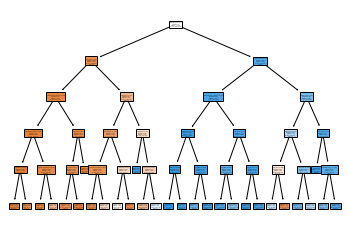

In [126]:
dtc = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 5)

dtc.fit(X_train_resampled, y_train_resampled)

tree.plot_tree(dtc,
             feature_names = processed_columns,
             class_names = np.unique(y_train).astype('str'),
             filled=True)

In [127]:
y_hat_train = dtc.predict(X_train_resampled)
y_hat_test = dtc.predict(processed_test)

print(classification_report(y_train_resampled, y_hat_train, target_names=target_names))
print(classification_report(y_test, y_hat_test, target_names=target_names))

              precision    recall  f1-score   support

     No Sale       0.92      0.88      0.90      8337
        Sale       0.88      0.92      0.90      8337

    accuracy                           0.90     16674
   macro avg       0.90      0.90      0.90     16674
weighted avg       0.90      0.90      0.90     16674

              precision    recall  f1-score   support

     No Sale       0.91      0.02      0.04      2085
        Sale       0.16      0.99      0.27       381

    accuracy                           0.17      2466
   macro avg       0.53      0.50      0.15      2466
weighted avg       0.79      0.17      0.07      2466



In [128]:
dtc_search = tree.DecisionTreeClassifier()

param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2, 5, 7, 10],
    'min_samples_split' : [2, 5, 10, 20]
}

gs_tree = GridSearchCV(dtc_search, param_grid, cv=3)
gs_tree.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 7, 10],
                         'min_samples_split': [2, 5, 10, 20]})

In [129]:
print(gs_tree.best_params_)

y_hat_train = gs_tree.predict(processed_train)
y_hat_test = gs_tree.predict(processed_test)

print(classification_report(y_train, y_hat_train, target_names=target_names))
print(classification_report(y_test, y_hat_test, target_names=target_names))

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
              precision    recall  f1-score   support

     No Sale       0.98      0.93      0.95      8337
        Sale       0.71      0.87      0.78      1527

    accuracy                           0.92      9864
   macro avg       0.84      0.90      0.87      9864
weighted avg       0.93      0.92      0.93      9864

              precision    recall  f1-score   support

     No Sale       0.94      0.31      0.46      2085
        Sale       0.19      0.88      0.31       381

    accuracy                           0.40      2466
   macro avg       0.56      0.60      0.39      2466
weighted avg       0.82      0.40      0.44      2466



#### Random Forest

### Evaluating